In [1]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# This is Keras/TensorFlow right? I thought this was Deep Learning?

- Output = activation(dot(input, kernel) + bias

That looks familiar doesn't it? It looks almost identical to y = mx+b. The dot product is sum of the products in two sequences. Well, if there is only two sequences with a length of 1 then it is just the product of those two numbers. This simplifies down to the all to familiar y = mx + b.


## Setup

In [2]:
# Example of dot product of two sequences of length 1
np.dot(2,1) + 5

7

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 20-step windows for training. Every 20 steps is 1 trading month since the markets are only open Monday - Friday.

In [5]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6999


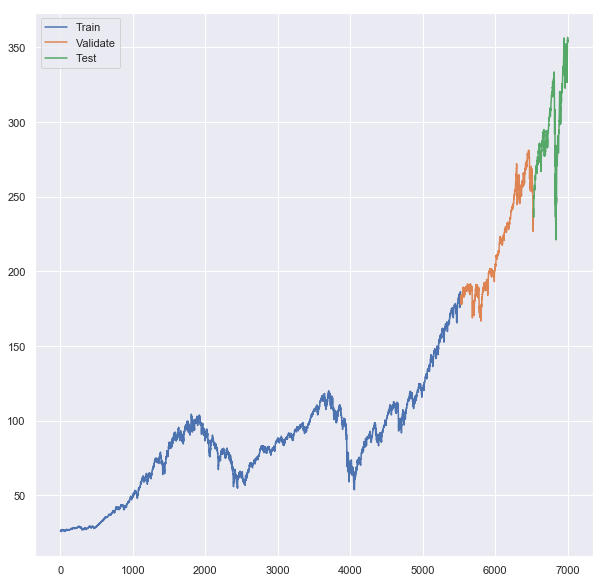

In [6]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [7]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

### Linear Model

In [8]:
# Clears any background saved info useful in notebooks
keras.backend.clear_session()

# Make reproducible 
tf.random.set_seed(42)
np.random.seed(42)

# set window size 
window_size = 20

# define training data (20 day windows shifted by 1 every time)
train_set = window_dataset(normalized_x_train.flatten(), window_size)

# Build Linear Model of a single dense layer
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Find optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.Nadam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
43/43 [==============================] - 1s 27ms/step - loss: 0.0483 - mae: 0.2672
Epoch 2/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0481 - mae: 0.2668
Epoch 3/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0480 - mae: 0.2664
Epoch 4/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0479 - mae: 0.2660
Epoch 5/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0478 - mae: 0.2657
Epoch 6/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0476 - mae: 0.2652
Epoch 7/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0474 - mae: 0.2648
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0473 - mae: 0.2643
Epoch 9/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0471 - mae: 0.2637
Epoch 10/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0469 - mae: 0.2632
Epoch 11/100
43/43 [=============================

43/43 [==============================] - 1s 23ms/step - loss: 3.1824e-04 - mae: 0.0201
Epoch 86/100
43/43 [==============================] - 1s 20ms/step - loss: 3.1093e-04 - mae: 0.0198
Epoch 87/100
43/43 [==============================] - 1s 21ms/step - loss: 3.0391e-04 - mae: 0.0194
Epoch 88/100
43/43 [==============================] - 1s 24ms/step - loss: 2.9704e-04 - mae: 0.0191
Epoch 89/100
43/43 [==============================] - 2s 42ms/step - loss: 2.9049e-04 - mae: 0.0188
Epoch 90/100
43/43 [==============================] - 2s 52ms/step - loss: 2.8420e-04 - mae: 0.0185
Epoch 91/100
43/43 [==============================] - 1s 30ms/step - loss: 2.7864e-04 - mae: 0.0182
Epoch 92/100
43/43 [==============================] - 1s 23ms/step - loss: 2.7344e-04 - mae: 0.0179
Epoch 93/100
43/43 [==============================] - 2s 47ms/step - loss: 2.6850e-04 - mae: 0.0176
Epoch 94/100
43/43 [==============================] - 2s 39ms/step - loss: 2.6463e-04 - mae: 0.0173
Epoch 95/100


[1e-06, 1, 0, 0.01]

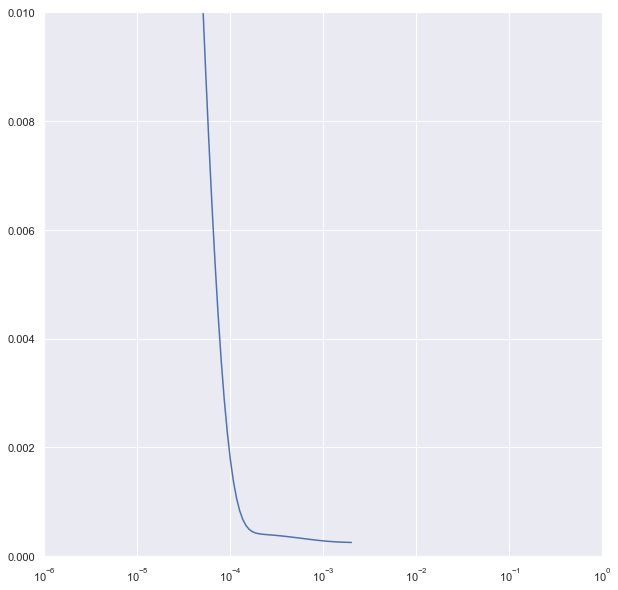

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .01])

In [10]:
# Useful to clear everything when rerunning cells
keras.backend.clear_session()

# Make this reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Create train and validate windows
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# 1 layer producing linear output for 1 output from each window of 20 days
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size]) # o
])

# Huber works well with "mae"
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])



Epoch 1/500
     43/Unknown - 2s 39ms/step - loss: 0.0978 - mae: 0.3946WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint/assets
43/43 [==============================] - 2s 54ms/step - loss: 0.0978 - mae: 0.3946 - val_loss: 0.3195 - val_mae: 0.7880
Epoch 2/500
43/43 [==============================] - 1s 29ms/step - loss: 0.0109 - mae: 0.1287 - val_loss: 0.0476 - val_mae: 0.3009
Epoch 3/500
43/43 [==============================] - 1s 28ms/step - loss: 0.0011 - mae: 0.0395 - val_loss: 0.0098 - val_mae: 0.1327
Epoch 4/500
43/43 [==============================] - 1s 29ms/step - loss: 6.7902e-04 - mae: 0.0291 - val_loss: 0.0050 - val

43/43 [==============================] - 1s 26ms/step - loss: 9.6267e-05 - mae: 0.0100 - val_loss: 3.9528e-04 - val_mae: 0.0198
Epoch 31/500
43/43 [==============================] - 1s 26ms/step - loss: 9.5737e-05 - mae: 0.0099 - val_loss: 3.8946e-04 - val_mae: 0.0198
Epoch 32/500
43/43 [==============================] - 1s 24ms/step - loss: 9.5133e-05 - mae: 0.0098 - val_loss: 4.0245e-04 - val_mae: 0.0197
Epoch 33/500
43/43 [==============================] - 1s 25ms/step - loss: 9.4733e-05 - mae: 0.0097 - val_loss: 3.9035e-04 - val_mae: 0.0197
Epoch 34/500
43/43 [==============================] - 1s 21ms/step - loss: 9.4378e-05 - mae: 0.0097 - val_loss: 3.9460e-04 - val_mae: 0.0197
Epoch 35/500
43/43 [==============================] - 1s 25ms/step - loss: 9.4292e-05 - mae: 0.0097 - val_loss: 3.8854e-04 - val_mae: 0.0197
Epoch 36/500
43/43 [==============================] - 1s 21ms/step - loss: 9.3999e-05 - mae: 0.0096 - val_loss: 3.9175e-04 - val_mae: 0.0197
Epoch 37/500
43/43 [======

Epoch 74/500
43/43 [==============================] - 1s 21ms/step - loss: 8.8606e-05 - mae: 0.0093 - val_loss: 3.6671e-04 - val_mae: 0.0191
Epoch 75/500
43/43 [==============================] - 1s 33ms/step - loss: 8.8348e-05 - mae: 0.0093 - val_loss: 3.6503e-04 - val_mae: 0.0191
Epoch 76/500
43/43 [==============================] - 1s 29ms/step - loss: 8.8092e-05 - mae: 0.0093 - val_loss: 3.6673e-04 - val_mae: 0.0190
Epoch 77/500
43/43 [==============================] - 1s 33ms/step - loss: 8.7964e-05 - mae: 0.0093 - val_loss: 3.6778e-04 - val_mae: 0.0190
Epoch 78/500
43/43 [==============================] - 1s 27ms/step - loss: 8.7690e-05 - mae: 0.0093 - val_loss: 3.6321e-04 - val_mae: 0.0191
Epoch 79/500
43/43 [==============================] - 1s 26ms/step - loss: 8.7581e-05 - mae: 0.0093 - val_loss: 3.6825e-04 - val_mae: 0.0192
Epoch 80/500
43/43 [==============================] - 2s 40ms/step - loss: 8.7442e-05 - mae: 0.0093 - val_loss: 3.5819e-04 - val_mae: 0.0190
Epoch 81/500


43/43 [==============================] - 1s 24ms/step - loss: 7.8560e-05 - mae: 0.0088 - val_loss: 3.2367e-04 - val_mae: 0.0180
Epoch 116/500
43/43 [==============================] - 1s 20ms/step - loss: 7.8326e-05 - mae: 0.0088 - val_loss: 3.2903e-04 - val_mae: 0.0181
Epoch 117/500
43/43 [==============================] - 1s 24ms/step - loss: 7.7988e-05 - mae: 0.0088 - val_loss: 3.2191e-04 - val_mae: 0.0179
Epoch 118/500
43/43 [==============================] - 1s 20ms/step - loss: 7.7613e-05 - mae: 0.0087 - val_loss: 3.2558e-04 - val_mae: 0.0180
Epoch 119/500
43/43 [==============================] - 1s 24ms/step - loss: 7.7472e-05 - mae: 0.0087 - val_loss: 3.1837e-04 - val_mae: 0.0178
Epoch 120/500
43/43 [==============================] - 1s 21ms/step - loss: 7.7279e-05 - mae: 0.0087 - val_loss: 3.4932e-04 - val_mae: 0.0189
Epoch 121/500
43/43 [==============================] - 1s 24ms/step - loss: 7.7190e-05 - mae: 0.0087 - val_loss: 3.1641e-04 - val_mae: 0.0176
Epoch 122/500
43/43 

43/43 [==============================] - 2s 39ms/step - loss: 6.6197e-05 - mae: 0.0081 - val_loss: 2.6604e-04 - val_mae: 0.0162
Epoch 156/500
43/43 [==============================] - 1s 23ms/step - loss: 6.6247e-05 - mae: 0.0081 - val_loss: 2.7228e-04 - val_mae: 0.0166
Epoch 157/500
43/43 [==============================] - 3s 66ms/step - loss: 6.6409e-05 - mae: 0.0081 - val_loss: 2.6478e-04 - val_mae: 0.0161
Epoch 158/500
43/43 [==============================] - 3s 68ms/step - loss: 6.5381e-05 - mae: 0.0080 - val_loss: 2.6578e-04 - val_mae: 0.0161
Epoch 159/500
43/43 [==============================] - 2s 41ms/step - loss: 6.5021e-05 - mae: 0.0080 - val_loss: 2.6696e-04 - val_mae: 0.0161
Epoch 160/500
43/43 [==============================] - 2s 47ms/step - loss: 6.4874e-05 - mae: 0.0080 - val_loss: 2.5653e-04 - val_mae: 0.0160
Epoch 161/500
43/43 [==============================] - 1s 31ms/step - loss: 6.4707e-05 - mae: 0.0080 - val_loss: 2.7737e-04 - val_mae: 0.0173
Epoch 162/500
43/43 

43/43 [==============================] - 2s 41ms/step - loss: 5.4648e-05 - mae: 0.0073 - val_loss: 2.1749e-04 - val_mae: 0.0150
Epoch 199/500
43/43 [==============================] - 2s 37ms/step - loss: 5.4907e-05 - mae: 0.0074 - val_loss: 2.1350e-04 - val_mae: 0.0147
Epoch 200/500
43/43 [==============================] - 1s 21ms/step - loss: 5.3887e-05 - mae: 0.0073 - val_loss: 2.4312e-04 - val_mae: 0.0156
Epoch 201/500
43/43 [==============================] - 1s 20ms/step - loss: 5.6199e-05 - mae: 0.0075 - val_loss: 2.5353e-04 - val_mae: 0.0161
Epoch 202/500
43/43 [==============================] - 1s 21ms/step - loss: 5.7599e-05 - mae: 0.0075 - val_loss: 2.5086e-04 - val_mae: 0.0171
Epoch 203/500
43/43 [==============================] - 1s 21ms/step - loss: 5.5744e-05 - mae: 0.0074 - val_loss: 2.2346e-04 - val_mae: 0.0147
Epoch 204/500
43/43 [==============================] - 1s 23ms/step - loss: 5.4340e-05 - mae: 0.0073 - val_loss: 2.1585e-04 - val_mae: 0.0145
Epoch 205/500
43/43 

43/43 [==============================] - 1s 23ms/step - loss: 4.7519e-05 - mae: 0.0068 - val_loss: 3.1325e-04 - val_mae: 0.0207
Epoch 243/500
43/43 [==============================] - 1s 29ms/step - loss: 4.6183e-05 - mae: 0.0068 - val_loss: 1.7744e-04 - val_mae: 0.0131
Epoch 244/500
43/43 [==============================] - 1s 24ms/step - loss: 4.5361e-05 - mae: 0.0067 - val_loss: 2.1547e-04 - val_mae: 0.0150
Epoch 245/500
43/43 [==============================] - 1s 31ms/step - loss: 4.6739e-05 - mae: 0.0068 - val_loss: 1.8735e-04 - val_mae: 0.0135
Epoch 246/500
43/43 [==============================] - 2s 36ms/step - loss: 4.4569e-05 - mae: 0.0066 - val_loss: 1.7354e-04 - val_mae: 0.0131
Epoch 247/500
43/43 [==============================] - 2s 55ms/step - loss: 4.6082e-05 - mae: 0.0067 - val_loss: 1.7253e-04 - val_mae: 0.0129
Epoch 248/500
43/43 [==============================] - 1s 29ms/step - loss: 4.4578e-05 - mae: 0.0066 - val_loss: 1.7315e-04 - val_mae: 0.0131
Epoch 249/500
43/43 

43/43 [==============================] - 1s 19ms/step - loss: 3.8900e-05 - mae: 0.0061 - val_loss: 1.5580e-04 - val_mae: 0.0123
Epoch 291/500
43/43 [==============================] - 1s 24ms/step - loss: 4.0509e-05 - mae: 0.0063 - val_loss: 1.4863e-04 - val_mae: 0.0119
Epoch 292/500
43/43 [==============================] - 1s 19ms/step - loss: 3.8687e-05 - mae: 0.0061 - val_loss: 1.6966e-04 - val_mae: 0.0137
Epoch 293/500
43/43 [==============================] - 1s 22ms/step - loss: 3.8362e-05 - mae: 0.0061 - val_loss: 1.6546e-04 - val_mae: 0.0128
Epoch 294/500
43/43 [==============================] - 1s 25ms/step - loss: 3.8056e-05 - mae: 0.0061 - val_loss: 1.8891e-04 - val_mae: 0.0141
Epoch 295/500
43/43 [==============================] - 1s 28ms/step - loss: 3.8441e-05 - mae: 0.0061 - val_loss: 1.4858e-04 - val_mae: 0.0123
Epoch 296/500
43/43 [==============================] - 1s 22ms/step - loss: 3.8215e-05 - mae: 0.0061 - val_loss: 1.5058e-04 - val_mae: 0.0124
Epoch 297/500
43/43 

43/43 [==============================] - 1s 21ms/step - loss: 3.5142e-05 - mae: 0.0058 - val_loss: 1.4840e-04 - val_mae: 0.0121
Epoch 339/500
43/43 [==============================] - 1s 33ms/step - loss: 3.4629e-05 - mae: 0.0058 - val_loss: 1.2799e-04 - val_mae: 0.0111
Epoch 340/500
43/43 [==============================] - 1s 22ms/step - loss: 3.3984e-05 - mae: 0.0057 - val_loss: 1.4911e-04 - val_mae: 0.0122
Epoch 341/500
43/43 [==============================] - 1s 21ms/step - loss: 3.5050e-05 - mae: 0.0059 - val_loss: 1.3345e-04 - val_mae: 0.0119
Epoch 342/500
43/43 [==============================] - 1s 19ms/step - loss: 3.4936e-05 - mae: 0.0058 - val_loss: 1.3285e-04 - val_mae: 0.0112
Epoch 343/500
43/43 [==============================] - 1s 26ms/step - loss: 3.4255e-05 - mae: 0.0057 - val_loss: 1.2948e-04 - val_mae: 0.0110
Epoch 344/500
43/43 [==============================] - 1s 27ms/step - loss: 3.4348e-05 - mae: 0.0058 - val_loss: 1.5583e-04 - val_mae: 0.0125
Epoch 345/500
43/43 

In [11]:
lin_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

In [12]:
# Undo the scaling
lin_forecast = x_train_scaler.inverse_transform(lin_forecast.reshape(-1,1)).flatten()
lin_forecast.shape

(472,)

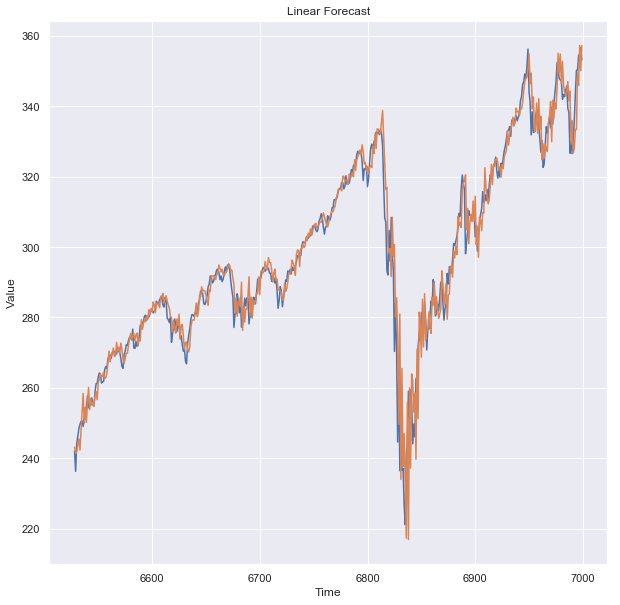

In [13]:
# Plot results
plt.title('Linear Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, lin_forecast)

#### Linear Model Result

In [14]:
keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()

3.8921304